In [3]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import old_references.nonlinear_QM_FPJPA as Fs
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.rabi as rabi
import standard_sequences.rabi_ef_swap as rabi_ef_swap
import standard_sequences.rabi_ef_no_swap as rabi_ef_no_swap
import classifiers.classifier as classifier
import analysis.analysis as analysis
import seaborn as sns
from scipy.optimize import curve_fit
import time
import traceback
from scipy.signal import savgol_filter

In [4]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)
bnc.set_bnc_output(
    general_vals_dict["TWPA_freq"],
    general_vals_dict["TWPA_pwr"],
    bnc_addr=bnc_address["big_agilent"],
)
general_vals_dict["wx_offs"] = [0.7, 0, -0.08, 0]  # offset to sweet spot

Qubit(ge_time=82, ef_amp=1.48, RO_LO_pwr=16, ro_dur=5000, ge_amp=0.795, ge_ssm=-0.1144, ro_freq=6.72739, qubit_thr=[-10000, -600], ROIF=0.10268999999999995, ef_time=49, qubit_id=q1, RO_LO=6.6247, ef_ssm=-0.2568, ro_amp=0.15, IQ_angle=110, RO_IF=None)
Qubit(ge_time=55, ef_amp=1, RO_LO_pwr=16, ro_dur=5000, ge_amp=0.8, ge_ssm=-0.154, ro_freq=6.65554, qubit_thr=[-10000, 1900], ROIF=0.030840000000000423, ef_time=None, qubit_id=q2, RO_LO=6.6247, ef_ssm=-0.2962, ro_amp=0.7, IQ_angle=25, RO_IF=None)


In [5]:
a_to_J = ((2 * np.pi) / (2 * (2 * q1.ef_time * 10**-3))) / q1.ef_amp
        # if J is in units of rad/micros
J_to_a = 1 / a_to_J

In [6]:
def run_rabi_ef_swap(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    num_steps: int,
    sweep_time: float,
    swap_freq: float,
    swap_time: float,
    reps: int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi_ef_swap.rabi_ef_swap(
        q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time
    )
    # rabi_ef_swap.rabi_ef_swap_f(
    #     q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time
    # )
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})

    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified["predicted"]
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)

    # Compute time values as the index for the DataFrame.
    times = np.linspace(0, sweep_time / 1000, num_steps)

    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame(
        {
            "time": times,
            "P_f": probabilties["P_f"],
            "P_e": probabilties["P_e"],
            "P_g": probabilties["P_g"],
        },
        index=times,
    )

    df_pop = pd.DataFrame(
        {
            "time": times,
            "Pop_f": population["Pop_f"],
            "Pop_e": population["Pop_e"],
            "Pop_g": population["Pop_g"],
        },
        index=times,
    )

    return df_prob, df_pop, values


def sweep_J(J_list: list):
    """
    Sweeps the frequency for the ef transition.
    For each frequency, it runs the experiment (via run_rabi_ef_swap) which returns a
    probability-vs-time DataFrame. Then it compiles these results into a dictionary
    where the keys are the frequency values (floats) and the values are the corresponding
    DataFrames.

    Returns:
        probability_dataframes (dict): A dictionary mapping frequency values to DataFrames.
            Each DataFrame has rows corresponding to time values (computed as
            np.linspace(0, sweep_time/1000, num_steps)) and columns for the state probabilities.
    """
    # Ensure the output directories exist

    probs_folder = os.path.join("sweep_J_data", "probs")
    values_folder = os.path.join("sweep_J_data", "values")
    os.makedirs(probs_folder, exist_ok=True)
    os.makedirs(values_folder, exist_ok=True)
    num_steps = 101
    reps = 6000
    sweep_time = 40000
    swap_freq = -0.0194
    swap_time = 0.5 * 7 / abs(swap_freq)

    # Create an array of frequency values
    J_vals = J_list

    # Initialize the dictionary with frequency keys set to None (or an empty placeholder)
    return_dict = {}
    return_vals = {}

    
    # Loop over frequencies and populate the dictionary
    for J in J_vals:
        prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
        values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")

        # If both files already exist, load them and skip this iteration
        if os.path.exists(prob_filename) and os.path.exists(values_filename):
            with open(prob_filename, "rb") as f:
                df_prob = pickle.load(f)
            with open(values_filename, "rb") as f:
                values = pickle.load(f)
            return_dict[J] = df_prob
            return_vals[J] = values
            continue  # Skip to the next J value
        ef_amp = J * J_to_a
        q1.ef_amp = ef_amp
        df_prob, df_pop, values = run_rabi_ef_swap(
            q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time, reps
        )
        # Populate the dictionary at the corresponding frequency key
        return_dict[J] = df_prob
        return_vals[J] = values

        # Create filenames with the current J value
        prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
        values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")

        # Save df_prob to a pickle file
        with open(prob_filename, "wb") as f:
            pickle.dump(df_prob, f)
            del df_prob
        # Save values to a pickle file
        with open(values_filename, "wb") as f:
            pickle.dump(values, f)
            del values
    return return_dict, return_vals

In [7]:
# def run_rabi_ef_no_swap(
#     q1: object,
#     q2: object,
#     general_vals_dict: dict,
#     ef_amp: float,
#     num_steps: int,
#     sweep_time: float,
#     reps: int,
# ):
#     """
#     Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
#     and processes the resulting IQ data to compute probabilities vs. time.

#     Returns:
#         df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
#                                 np.linspace(0, sweep_time/1000, num_steps)) and which has
#                                 columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
#                                 of the f, e, and g states respectively.
#     """
#     # Run the experiment
#     rabi_ef_no_swap.rabi_ef_no_swap(
#         q1,
#         q2,
#         general_vals_dict,
#         ef_amp,
#         num_steps,
#         sweep_time,
#     )
#     wx.wx_set_and_amplitude_and_offset(
#         amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
#     )
#     # Acquire the raw IQ data
#     values = daq.run_daq_het_2q(
#         q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
#     )

#     return values


# def run_swap(
#     q1: object,
#     q2: object,
#     general_vals_dict: dict,
#     swap_freq: float,
#     num_steps: int,
#     sweep_time: float,
#     reps: int,
# ):
#     """
#     Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
#     and processes the resulting IQ data to compute probabilities vs. time.

#     Returns:
#         df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
#                                 np.linspace(0, sweep_time/1000, num_steps)) and which has
#                                 columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
#                                 of the f, e, and g states respectively.
#     """
#     # Run the experiment
#     rabi_ef_swap.swap(q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq)
#     wx.wx_set_and_amplitude_and_offset(
#         amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
#     )
#     # Acquire the raw IQ data
#     values = daq.run_daq_het_2q(
#         q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
#     )

#     return values

In [8]:
J_start = 0
J_stop = 1.5
J_steps = 151
# J_list = np.linspace(10, 10,1)#
J_list = np.linspace(J_start, J_stop, J_steps)
# Main loop: if an error occurs, print it, wait, and restart
# while True:
#     try:
#         #rx, ry = run_amp_measurements()
#         J_dict, vals_dict = sweep_J(J_list)
#         break  # Exit loop when measurements complete successfully
#     except Exception as e:
#         print("An error occurred:")
#         traceback.print_exc()
#         print("Restarting in 5 seconds...")
#         time.sleep(5)


In [33]:
def sweep_J_curve_fit(probability_dataframes):
    """
    Loops over each J in the probability_dataframes dictionary, performs a
    renormalization and curve fit on the P_f data, and returns a dictionary
    mapping J values to the extracted Rabi angular frequency.

    Parameters:
        probability_dataframes (dict): Dictionary with keys as J values and values as
                                       DataFrames containing columns 'time', 'P_f', 'P_e', etc.
        guess_gamma (float): Initial guess for gamma used in the curve fit for J <= 0.25.
        guess_freq (float): Initial guess for frequency used in the curve fit for J > 0.25.

    Returns:
        omega_values (dict): Dictionary mapping each J value to its extracted angular frequency
                             in rad/µs.
    """
    omega_values = {}

    for J, df in probability_dataframes.items():
        # Extract the time and state probability data from the DataFrame
        times = df["time"].values
        P_f = df["P_f"].values
        P_e = df["P_e"].values
        # print(J)
        # Renormalize: P_f_norm = P_f / (P_f + P_e)
        norm_factor = P_f + P_e
        # Avoid division by zero (if that case can ever occur)
        norm_factor[norm_factor == 0] = 1

        guess_gamma =np.sqrt( abs(0.14**2 - J**2))
        guess_freq = np.sqrt(abs(0.14**2 - J**2)) / np.pi
        # Select initial guess values based on J
        # if 0 <= J <= 0.05:
        #     # For J in the range 0 - 0.05
        #     window_length = 21  # must be odd
        #     poly_order = 3
        #     P_f_norm = savgol_filter(P_f, window_length, poly_order)
        #     lower_bounds = [0, 0,0, 0, -np.inf]
        #     upper_bounds = [.01,0.6,np.inf, np.inf, np.inf]
        #     guess_vals = [0, .56,100, 0, 0.025]
    

        # elif 0.06 <= J <= 0.12:
        #     # For J in the range 0.06 - 0.12
        #     window_length = 21
        #     poly_order = 23
        #     P_f_norm = savgol_filter(P_f, window_length, poly_order)
        #     lower_bounds = [0, 0,0, 0, -np.inf]
        #     upper_bounds = [.01,0.6,np.inf, np.inf, np.inf]
        #     guess_vals = [0, .56,100, 0, 0.025]
        # elif 0.13 <= J <= 0.21:
        #     # For J in the range 0.13 - 0.21
        #     window_length = 21
        #     poly_order = 3
        #     P_f_norm = savgol_filter(P_f, window_length, poly_order)
        #     lower_bounds = [0, 0,0, 0, -np.inf]
        #     upper_bounds = [.01,0.6,np.inf, np.inf, np.inf]
        #     guess_vals = [0, .56,100, 0, 0.025]
    
        # elif 0.22 <= J <= 0.27:
        #      # For J in the range 0.22 - 0.27
        #     window_length = 21
        #     poly_order = 3
        #     P_f_norm = savgol_filter(P_f, window_length, poly_order)
        #     lower_bounds = [0, 0,0, 0, -np.inf]
        #     upper_bounds = [.01,0.6,np.inf, np.inf, np.inf]
        #     guess_vals = [0, .56,100, 0, 0.025]
   
        # elif J >= 0.28:
        #     # For J >= 0.28, you may choose to not filter the data.
        #     P_f_norm = P_f  # Or apply a different processing if needed
        #     lower_bounds = [0, 0.4, 0, -np.inf, -np.inf]
        #     upper_bounds = [0.3, 0.6, np.inf, np.inf, np.inf]
        #     # Example guess value using your provided expression; adjust as needed.
        #     guess_vals = [0, 0.5, (J / np.sqrt(abs(0.2**2 - J**2)))**2, 0, 0.02]
    
    
    
        if J <= 0.28:
            # Apply Savitzky-Golay filter
            window_length = 21  # must be odd; try 7, 9, 11, ...
            poly_order = 3     # polynomial order
            P_f_norm  = savgol_filter(P_f , window_length, poly_order)#P_f#/ norm_factor
            lower_bounds = [0, 0,0, 0, -np.inf]
            upper_bounds = [.01,0.6,np.inf, np.inf, np.inf]
            guess_vals = [0, .56,100, 0, 0.025]
        else:
            P_f_norm = P_f #/  norm_factor
            lower_bounds = [0, 0.4,0, -np.inf, -np.inf]
            upper_bounds = [.3,0.6,np.inf, np.inf, np.inf]
            guess_vals = [0, 0.5, (J/np.sqrt(abs(0.2**2 - J**2)) )**2, 0, 0.02]#0,0.55  , 
        # guess_vals = [0, guess_gamma, 0.1, -10, 0.03]
        # Perform the curve fit using analysis.fit_sine_decay.
        # It is assumed that this function returns a tuple where the first element
        # is an array of fit parameters, with the first parameter corresponding to frequency.
        fit_vals_f, _, _, _ = analysis.fit_sine_square_decay(
            times, P_f_norm, guess_vals=guess_vals,lower_bounds=lower_bounds,upper_bounds=upper_bounds
            
        )

        # Calculate the angular frequency: omega = |(freq * 2π)|
        omega_rabi_f = abs(fit_vals_f[0] * 2 * np.pi)

        print(f"J = {J}: Angular freq (rad/µs): {omega_rabi_f}")
        omega_values[J] = omega_rabi_f

    return omega_values

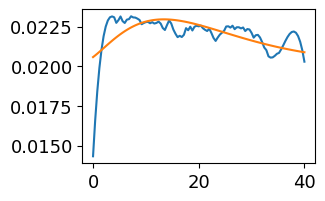

freq:0.0005945338578129162,gamma: 0.1246742307478066, amp:4.120212953445558, phase_deg: 0.5667543074004253,offset: 0.020180974781384566,
J = 0.0: Angular freq (rad/µs): 0.0037355664000309125


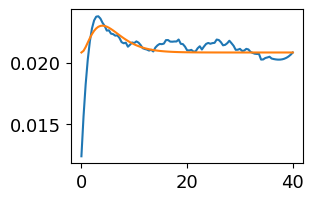

freq:0.0003585140124615733,gamma: 0.5044039677677603, amp:201.508013505333, phase_deg: 8.78814072417301e-33,offset: 0.02082732264914804,
J = 0.01: Angular freq (rad/µs): 0.0022526099755165565


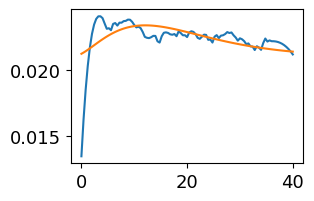

freq:0.0007715054578589843,gamma: 0.1451231130222263, amp:3.0377062391902454, phase_deg: 0.47214814104282776,offset: 0.0209976177684423,
J = 0.02: Angular freq (rad/µs): 0.004847511757228429


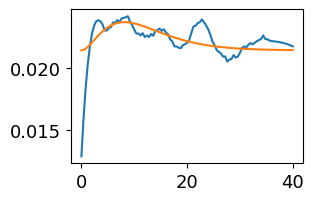

freq:0.0012408260413833206,gamma: 0.24453710467386536, amp:4.082775738031305, phase_deg: 0.02081687644335494,offset: 0.021418321469857116,
J = 0.03: Angular freq (rad/µs): 0.007796339951985489


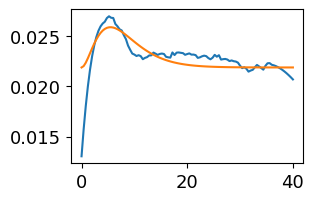

freq:0.0001745384338714925,gamma: 0.36574597486165117, amp:821.8397900315647, phase_deg: 2.3314060615860876e-31,offset: 0.021885473467395895,
J = 0.04: Angular freq (rad/µs): 0.0010966573232394975


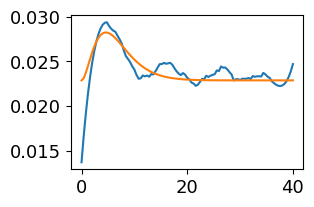

freq:0.009999999999999978,gamma: 0.4226229199157658, amp:0.4611671625646955, phase_deg: 7.1651713541032e-34,offset: 0.022863024655873088,
J = 0.05: Angular freq (rad/µs): 0.06283185307179572
RuntimeError


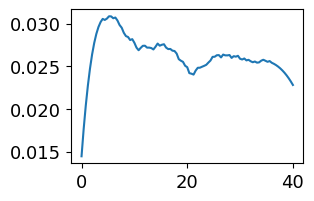

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.06: Angular freq (rad/µs): nan
RuntimeError


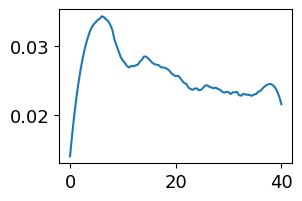

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.07: Angular freq (rad/µs): nan
RuntimeError


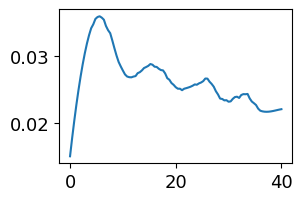

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.08: Angular freq (rad/µs): nan
RuntimeError


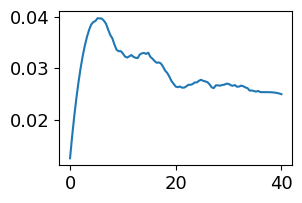

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.09: Angular freq (rad/µs): nan


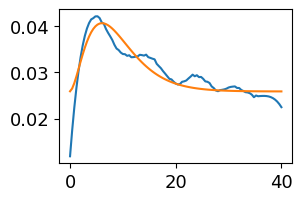

freq:0.0014416440193122308,gamma: 0.32428724491039335, amp:33.77366091426905, phase_deg: 0.058394917359568,offset: 0.025856650472754122,
J = 0.1: Angular freq (rad/µs): 0.009058116520325933
RuntimeError


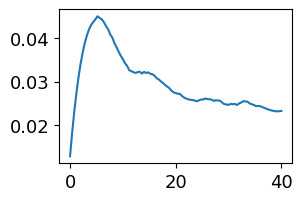

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.11: Angular freq (rad/µs): nan


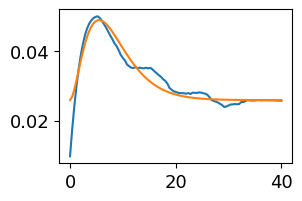

freq:0.0014061298646721643,gamma: 0.3597489271321656, amp:69.2523952250925, phase_deg: 0.028576282975598218,offset: 0.025938434494175548,
J = 0.12: Angular freq (rad/µs): 0.008834974505694563
RuntimeError


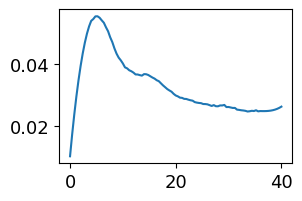

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.13: Angular freq (rad/µs): nan
RuntimeError


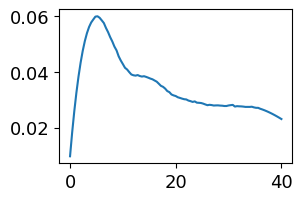

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.14: Angular freq (rad/µs): nan
RuntimeError


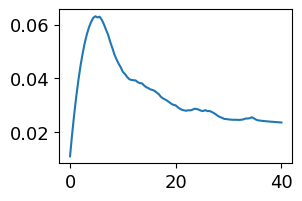

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.15: Angular freq (rad/µs): nan
RuntimeError


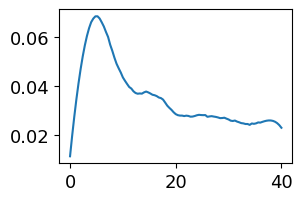

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.16: Angular freq (rad/µs): nan
RuntimeError


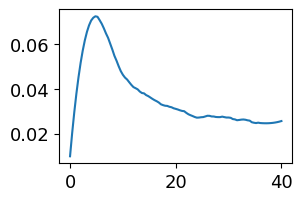

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.17: Angular freq (rad/µs): nan


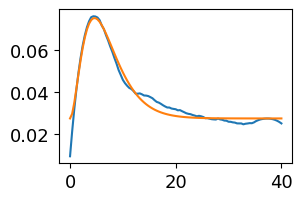

freq:0.0014433067152259,gamma: 0.43173896416832797, amp:200.04687160067488, phase_deg: 1.6283008263862775e-09,offset: 0.02743564044152937,
J = 0.18: Angular freq (rad/µs): 0.009068563546861006
RuntimeError


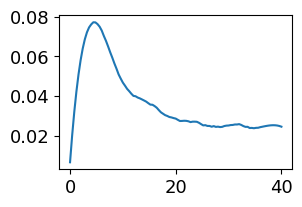

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.19: Angular freq (rad/µs): nan
RuntimeError


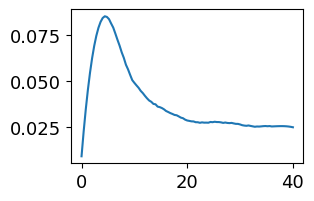

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.2: Angular freq (rad/µs): nan


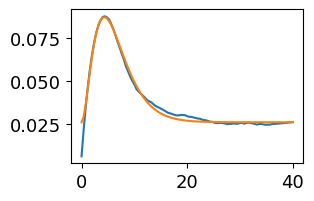

freq:0.002046570461788217,gamma: 0.463903916097201, amp:146.6251585211415, phase_deg: 5.867741516761021e-10,offset: 0.02626812331337049,
J = 0.21: Angular freq (rad/µs): 0.012858981455615467
RuntimeError


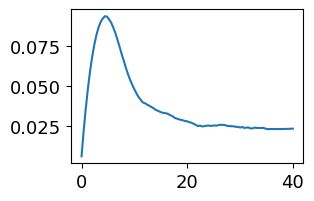

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.22: Angular freq (rad/µs): nan
RuntimeError


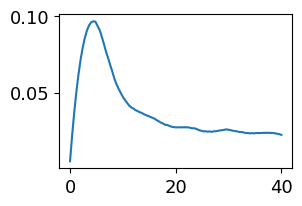

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.23: Angular freq (rad/µs): nan


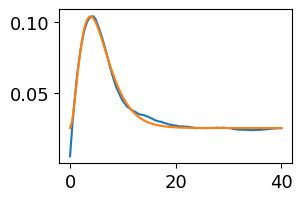

freq:0.002497982401874262,gamma: 0.5177750010777947, amp:158.68923834952633, phase_deg: 1.1967131184636795e-08,offset: 0.02550258903159112,
J = 0.24: Angular freq (rad/µs): 0.015695286325049535


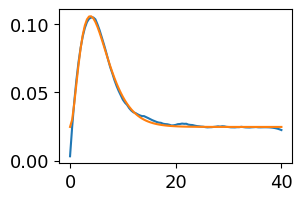

freq:0.002427669583468731,gamma: 0.5214642345684667, amp:175.93556488018856, phase_deg: 9.036734854583163e-07,offset: 0.02465927157903522,
J = 0.25: Angular freq (rad/µs): 0.015253497857537518
RuntimeError


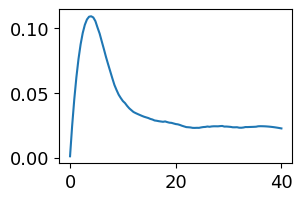

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.26: Angular freq (rad/µs): nan
RuntimeError


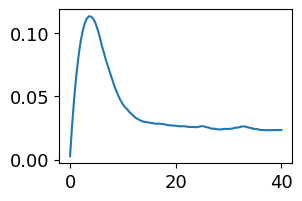

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.27: Angular freq (rad/µs): nan
RuntimeError


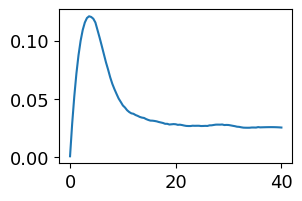

freq:nan,gamma: nan, amp:nan, phase_deg: nan,offset: nan,
J = 0.28: Angular freq (rad/µs): nan


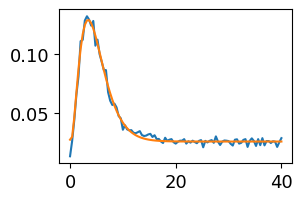

freq:0.010156990405372702,gamma: 0.5999999999999999, amp:18.772847652135766, phase_deg: -0.5196866683391815,offset: 0.025443895530802202,
J = 0.29: Angular freq (rad/µs): 0.06381825288020179


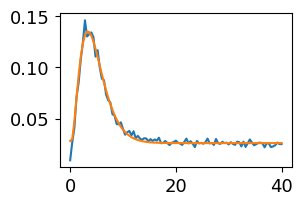

freq:0.01780869732439598,gamma: 0.5999999999999999, amp:6.6496513306116425, phase_deg: -1.0003625990261165,offset: 0.02612054295060237,
J = 0.3: Angular freq (rad/µs): 0.11189534536865324


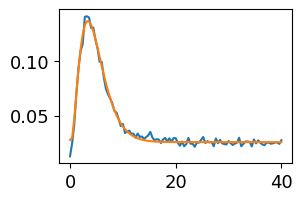

freq:0.016091237244632833,gamma: 0.5999999999989482, amp:8.215209911408074, phase_deg: -0.8934288299365861,offset: 0.02579900158086238,
J = 0.31: Angular freq (rad/µs): 0.10110422542981794


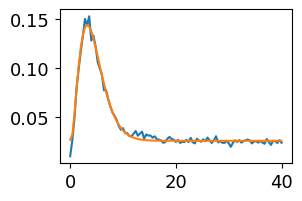

freq:0.022897348923218767,gamma: 0.5999999999999959, amp:4.384640059267783, phase_deg: -0.9319010271267377,offset: 0.025688149992895853,
J = 0.32: Angular freq (rad/µs): 0.14386828632773246


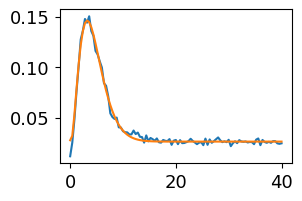

freq:0.022864790388548162,gamma: 0.5999999999999999, amp:4.4608000165882995, phase_deg: -0.9831047586215698,offset: 0.02621693150587527,
J = 0.33: Angular freq (rad/µs): 0.14366371502106684


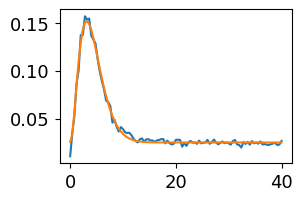

freq:0.0258862640350774,gamma: 0.5999999999999999, amp:3.6306909288000866, phase_deg: -0.630698070491723,offset: 0.025080409220650177,
J = 0.34: Angular freq (rad/µs): 0.16264819384296966


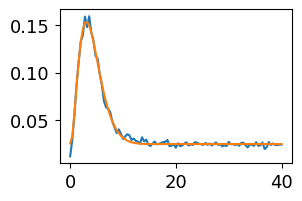

freq:0.029726570381949195,gamma: 0.5999999999996204, amp:2.90115602912756, phase_deg: -0.8909288228705782,offset: 0.024847788935373136,
J = 0.35000000000000003: Angular freq (rad/µs): 0.18677755025670303


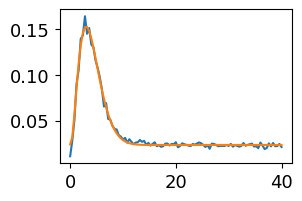

freq:0.03183831032905742,gamma: 0.5999999999999996, amp:2.57768396817175, phase_deg: -0.9037284424179712,offset: 0.023372312965314068,
J = 0.36: Angular freq (rad/µs): 0.20004600366495764


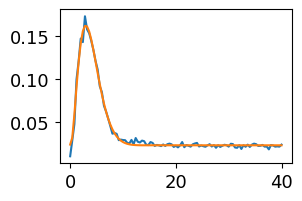

freq:0.035283459805021365,gamma: 0.5999999999999059, amp:2.3150509971643465, phase_deg: -1.0627650994452165,offset: 0.023237566987405367,
J = 0.37: Angular freq (rad/µs): 0.22169251623337174


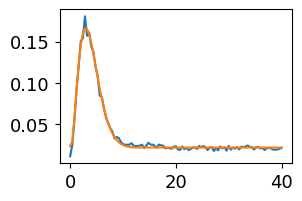

freq:0.03725375601823401,gamma: 0.5999999999999996, amp:2.2215205271327894, phase_deg: -1.4381910093217198,offset: 0.02219420467459397,
J = 0.38: Angular freq (rad/µs): 0.234072252451021


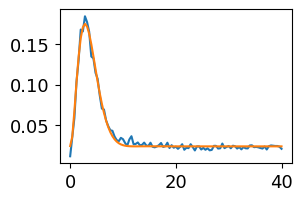

freq:0.04094538418664802,gamma: 0.5999999999999999, amp:1.9183008014674818, phase_deg: -0.7902382240658944,offset: 0.024032282061421464,
J = 0.39: Angular freq (rad/µs): 0.2572674363183702


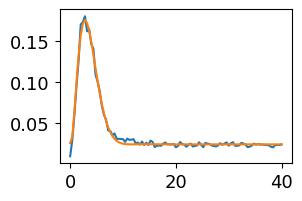

freq:0.043639813979282994,gamma: 0.5999999999999706, amp:1.806845438254376, phase_deg: -1.7055050017272388,offset: 0.02377868568963173,
J = 0.4: Angular freq (rad/µs): 0.27419703800268125


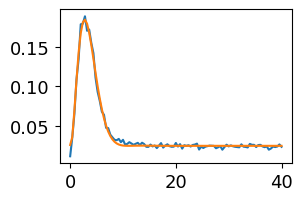

freq:0.04587289926763077,gamma: 0.5999999999999999, amp:1.7238173270578303, phase_deg: -1.415916298948006,offset: 0.024885246197091624,
J = 0.41000000000000003: Angular freq (rad/µs): 0.28822792667610686


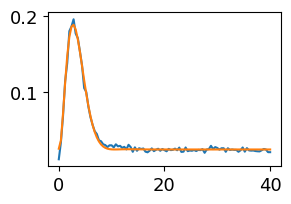

freq:0.047691987205466795,gamma: 0.5999999999999999, amp:1.6606434165368835, phase_deg: -1.3996822082789002,offset: 0.02487404636074088,
J = 0.42: Angular freq (rad/µs): 0.2996575932795858


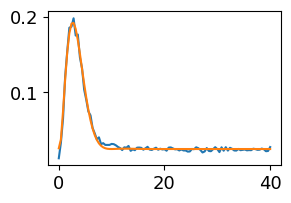

freq:0.050666513925869315,gamma: 0.5999999999999878, amp:1.541746155907443, phase_deg: -1.4253967901595308,offset: 0.024909907303499918,
J = 0.43: Angular freq (rad/µs): 0.31834709586503196


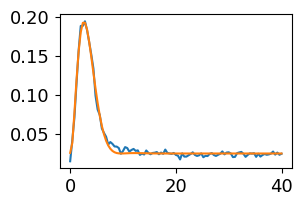

freq:0.0520612302036899,gamma: 0.5999999999974642, amp:1.4840529361403836, phase_deg: -1.3301477265167547,offset: 0.024815655322607107,
J = 0.44: Angular freq (rad/µs): 0.3271103566895185


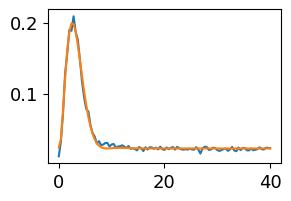

freq:0.05524104469918834,gamma: 0.5999999999999999, amp:1.4379892457386878, phase_deg: -1.6895959453739122,offset: 0.022535914644679585,
J = 0.45: Angular freq (rad/µs): 0.34708972040719094


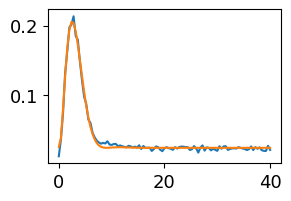

freq:0.0560422196535328,gamma: 0.5999999999999999, amp:1.4462627086449613, phase_deg: -1.685289623993971,offset: 0.023533097535563267,
J = 0.46: Angular freq (rad/µs): 0.35212365110880833


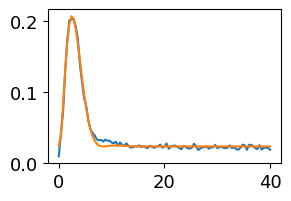

freq:0.059917688835533674,gamma: 0.584849837105702, amp:1.2666850879199767, phase_deg: -1.6599969165959676,offset: 0.023511181295281444,
J = 0.47000000000000003: Angular freq (rad/µs): 0.3764739421315835


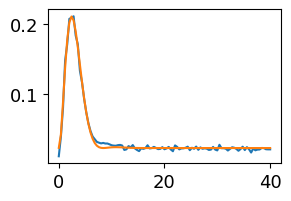

freq:0.059695014789982015,gamma: 0.5999999999999993, amp:1.3155157910811381, phase_deg: -0.7857401713278025,offset: 0.023384619693173115,
J = 0.48: Angular freq (rad/µs): 0.3750748398402831


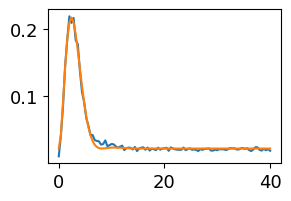

freq:0.061526230185162296,gamma: 0.5999999999999657, amp:1.3116694285937247, phase_deg: -0.7618053013655582,offset: 0.022516128238712355,
J = 0.49: Angular freq (rad/µs): 0.3865807055055609


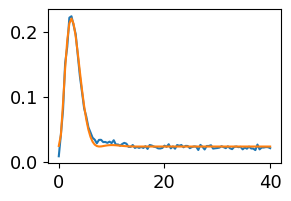

freq:0.06546456677396757,gamma: 0.5869329259732557, amp:1.200838255402067, phase_deg: -1.5762044105793327,offset: 0.023331191051043608,
J = 0.5: Angular freq (rad/µs): 0.41132600409507


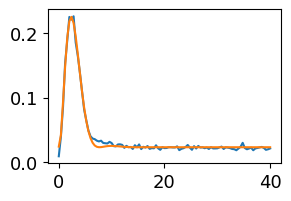

freq:0.06562370540529562,gamma: 0.5999999999999999, amp:1.2659940293414869, phase_deg: -1.565492784358648,offset: 0.023009005346278602,
J = 0.51: Angular freq (rad/µs): 0.412325901605235


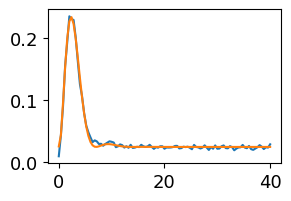

freq:0.07155731397426895,gamma: 0.5475217213870204, amp:1.0342157336675446, phase_deg: -1.5931451966730317,offset: 0.024571733846213816,
J = 0.52: Angular freq (rad/µs): 0.4496078637843632


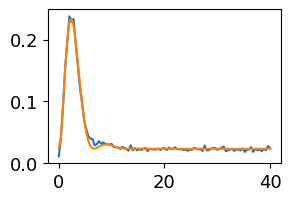

freq:0.07548195278463596,gamma: 0.5139960538571987, amp:0.9040671554522697, phase_deg: -1.650098843704656,offset: 0.023293432543426813,
J = 0.53: Angular freq (rad/µs): 0.4742670966936479


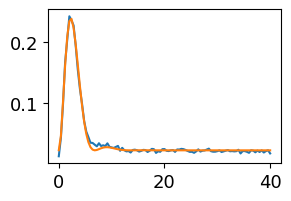

freq:0.07366217084125691,gamma: 0.550412235590014, amp:1.0204030802266497, phase_deg: -0.8557518144176374,offset: 0.02224982988233994,
J = 0.54: Angular freq (rad/µs): 0.46283306952473796


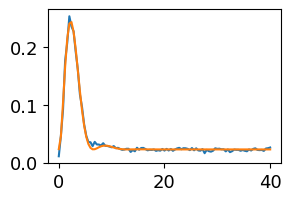

freq:0.07683213187225117,gamma: 0.5398439716405726, amp:0.9802695460731851, phase_deg: -1.2975842330333829,offset: 0.02304900387731444,
J = 0.55: Angular freq (rad/µs): 0.482750522099013


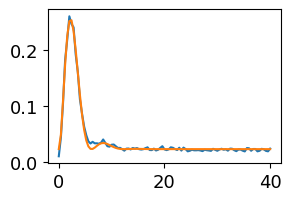

freq:0.08092491750400674,gamma: 0.4943294723651835, amp:0.8621028412516464, phase_deg: -0.6572872252719,offset: 0.022589747226601953,
J = 0.56: Angular freq (rad/µs): 0.5084662526458953


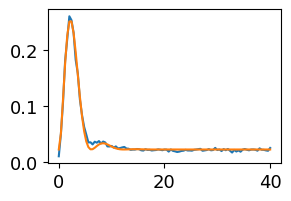

freq:0.08119214620555637,gamma: 0.49252055667358824, amp:0.8439242790760103, phase_deg: -0.03989609301394207,offset: 0.02229175730957484,
J = 0.5700000000000001: Angular freq (rad/µs): 0.5101453000971286


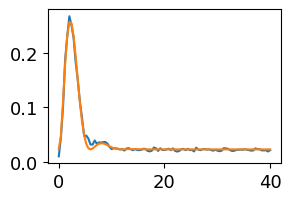

freq:0.08426151933638372,gamma: 0.5126154461459563, amp:0.8856664630440766, phase_deg: -1.506361829525551,offset: 0.02302572443319573,
J = 0.58: Angular freq (rad/µs): 0.5294307402549948


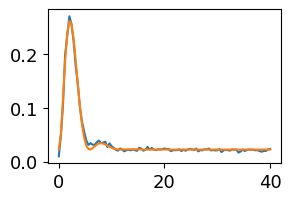

freq:0.08551832836753726,gamma: 0.5139624084775578, amp:0.8770451521983141, phase_deg: -0.7303060436263239,offset: 0.02250645788332397,
J = 0.59: Angular freq (rad/µs): 0.5373275042934693


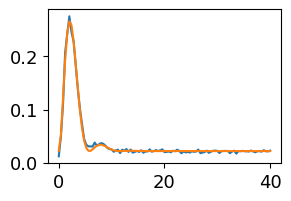

freq:0.08654078257521175,gamma: 0.5207477309129234, amp:0.8942680653558331, phase_deg: -0.6689907260691117,offset: 0.02192751036065936,
J = 0.6: Angular freq (rad/µs): 0.5437517735483937


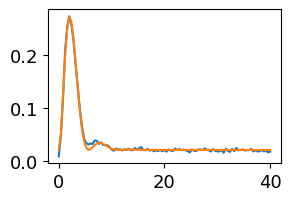

freq:0.08838807731299772,gamma: 0.5167189877186924, amp:0.8847990358040022, phase_deg: -0.566052528821012,offset: 0.021298990773014583,
J = 0.61: Angular freq (rad/µs): 0.5553586687028806


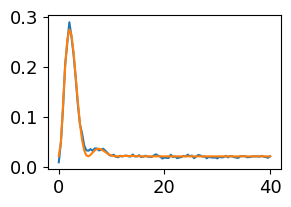

freq:0.09126032565456088,gamma: 0.5133663106296009, amp:0.8726543372294505, phase_deg: -1.4878879859319523,offset: 0.021156195464716133,
J = 0.62: Angular freq (rad/µs): 0.5734055372811612


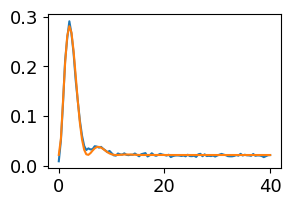

freq:0.09190597638911434,gamma: 0.506293952223286, amp:0.8649846996500643, phase_deg: -0.7963239844866314,offset: 0.02146592334418015,
J = 0.63: Angular freq (rad/µs): 0.5774622804900772


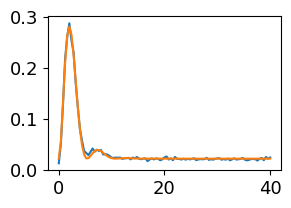

freq:0.0934264709259963,gamma: 0.5079085282811838, amp:0.8491645781131832, phase_deg: -0.58621443130109,offset: 0.02174412413209351,
J = 0.64: Angular freq (rad/µs): 0.5870158294238608


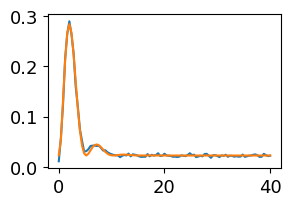

freq:0.09722042817386671,gamma: 0.48106137898699913, amp:0.7868620644045506, phase_deg: -1.1407910758896576,offset: 0.022643544223882206,
J = 0.65: Angular freq (rad/µs): 0.6108539658597476


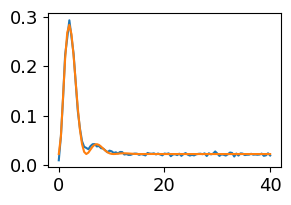

freq:0.09642931213230496,gamma: 0.4956162815542056, amp:0.8092700365761168, phase_deg: -0.5098287049865908,offset: 0.022285850311464295,
J = 0.66: Angular freq (rad/µs): 0.6058832371711328


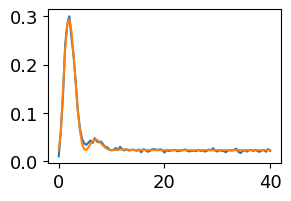

freq:0.09914232860240904,gamma: 0.49847217940294647, amp:0.8173626753995263, phase_deg: -0.04319457846126195,offset: 0.02292204838080349,
J = 0.67: Angular freq (rad/µs): 0.6229296223942269


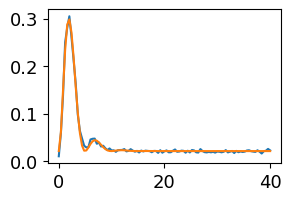

freq:0.10085627790489256,gamma: 0.5030332941372868, amp:0.837178288522444, phase_deg: -0.5938660705800094,offset: 0.021407860715129595,
J = 0.68: Angular freq (rad/µs): 0.6336986834688421


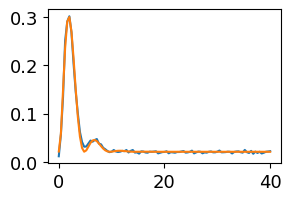

freq:0.10364016566623288,gamma: 0.5052228163916278, amp:0.8348737559892355, phase_deg: -1.395974168323828,offset: 0.021311562506715485,
J = 0.6900000000000001: Angular freq (rad/µs): 0.6511903661477326


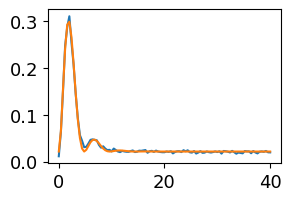

freq:0.10377817321327258,gamma: 0.4960224392359777, amp:0.8048132682423977, phase_deg: -0.03681970120627555,offset: 0.021806216800545855,
J = 0.7000000000000001: Angular freq (rad/µs): 0.6520574931395724


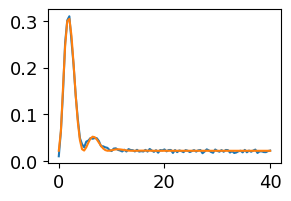

freq:0.10711036212825788,gamma: 0.48062252481861956, amp:0.7809584779583741, phase_deg: -0.6423737261743415,offset: 0.02208174014836239,
J = 0.71: Angular freq (rad/µs): 0.6729942535709547


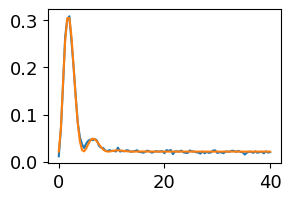

freq:0.10656666993058656,gamma: 0.49981524180163445, amp:0.8102290027663492, phase_deg: 0.46482393051167153,offset: 0.021270599757245514,
J = 0.72: Angular freq (rad/µs): 0.669578134742918


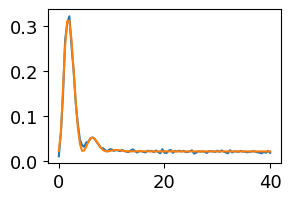

freq:0.11028717246687345,gamma: 0.5002107565988251, amp:0.8263557275244733, phase_deg: -1.656994382581025,offset: 0.021488580059430162,
J = 0.73: Angular freq (rad/µs): 0.6929547416142402


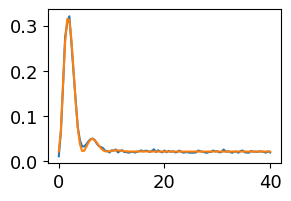

freq:0.10951419905622375,gamma: 0.5164441598167041, amp:0.8521101766088185, phase_deg: -0.6482771918913233,offset: 0.021460863195431643,
J = 0.74: Angular freq (rad/µs): 0.6880980064376057


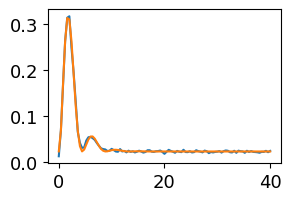

freq:0.11247638746483239,gamma: 0.49084735413109565, amp:0.7886209342772875, phase_deg: -0.8510856179654414,offset: 0.02260404694829688,
J = 0.75: Angular freq (rad/µs): 0.7067099851236731


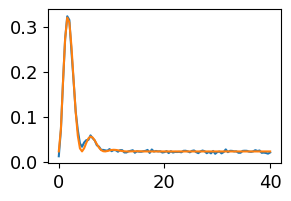

freq:0.11525460709692442,gamma: 0.5078622522224456, amp:0.8076468664400572, phase_deg: -0.6753571105306462,offset: 0.02259044810728214,
J = 0.76: Angular freq (rad/µs): 0.7241660538961516


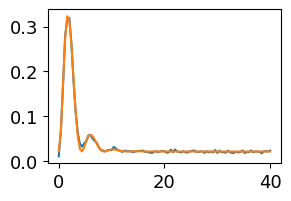

freq:0.11700526333192911,gamma: 0.4905282275212178, amp:0.792064306789656, phase_deg: -1.4295252581069327,offset: 0.021487901743919305,
J = 0.77: Angular freq (rad/µs): 0.7351657514298554


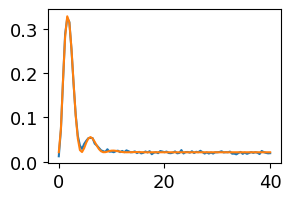

freq:0.11684898034030046,gamma: 0.5129958393443498, amp:0.8270565719470929, phase_deg: -0.6419437432184728,offset: 0.021535392763885795,
J = 0.78: Angular freq (rad/µs): 0.7341837964330922


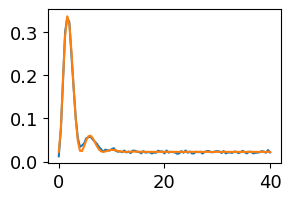

freq:0.11907562533792905,gamma: 0.5042636305841982, amp:0.8145938966568521, phase_deg: -0.374243107759453,offset: 0.022382565234480515,
J = 0.79: Angular freq (rad/µs): 0.7481742195664971


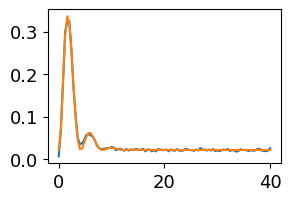

freq:0.12128879656187225,gamma: 0.4967762507754443, amp:0.8057128472743907, phase_deg: -1.5727577043006182,offset: 0.021861421488921243,
J = 0.8: Angular freq (rad/µs): 0.7620799844830496


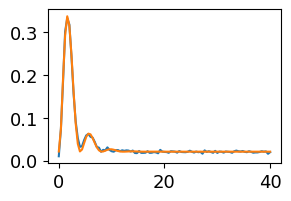

freq:0.12307370159885586,gamma: 0.4942002741145548, amp:0.7929553544843015, phase_deg: -1.1985932431048236,offset: 0.021254921346195475,
J = 0.81: Angular freq (rad/µs): 0.7732948735861359


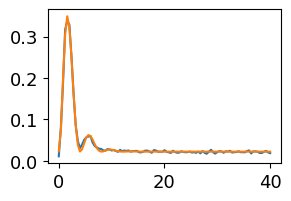

freq:0.12395619104844452,gamma: 0.5197443604414408, amp:0.8540914726713056, phase_deg: -1.7363095542715774,offset: 0.022214865753712686,
J = 0.8200000000000001: Angular freq (rad/µs): 0.7788397183295324


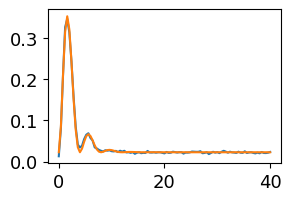

freq:0.12547393963388606,gamma: 0.5062136490524735, amp:0.8213811091076105, phase_deg: -0.244609347749901,offset: 0.022593276427726565,
J = 0.8300000000000001: Angular freq (rad/µs): 0.7883760139415712


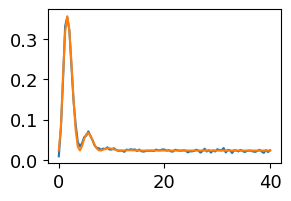

freq:0.12812032436459528,gamma: 0.5200158640717052, amp:0.8463038713170382, phase_deg: -1.6770154925183505,offset: 0.023199140551998218,
J = 0.84: Angular freq (rad/µs): 0.8050037395987079


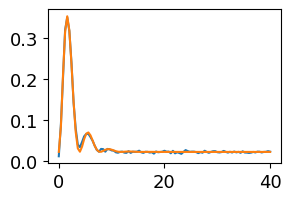

freq:0.12797526993420658,gamma: 0.4953826293144529, amp:0.8005311682773817, phase_deg: -0.5465783608545485,offset: 0.02235225973931475,
J = 0.85: Angular freq (rad/µs): 0.8040923357329482


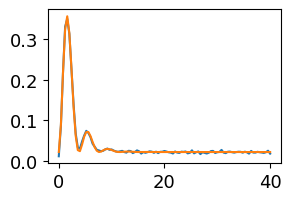

freq:0.13057205116942747,gamma: 0.49203083046790536, amp:0.7849384406481978, phase_deg: -0.06696646712649672,offset: 0.02242505480216092,
J = 0.86: Angular freq (rad/µs): 0.8204083934360478


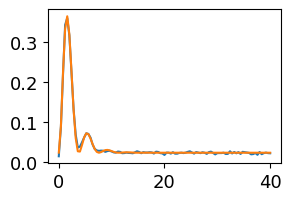

freq:0.13215937448397286,gamma: 0.51273361357936, amp:0.8271317055309627, phase_deg: -0.835440407160198,offset: 0.023530329224412855,
J = 0.87: Angular freq (rad/µs): 0.8303818399637429


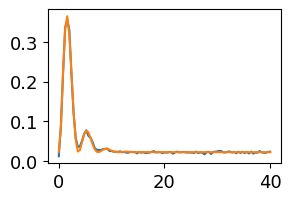

freq:0.13468906255296761,gamma: 0.49637849787697524, amp:0.8045248208658965, phase_deg: -1.3114565539620748,offset: 0.02212106049083485,
J = 0.88: Angular freq (rad/µs): 0.8462763388705983


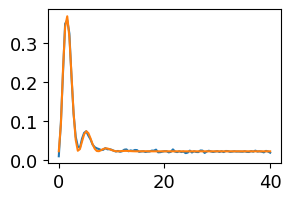

freq:0.13477596699678507,gamma: 0.5144937742523096, amp:0.8291570558740647, phase_deg: -0.6861406845165575,offset: 0.02236244631888297,
J = 0.89: Angular freq (rad/µs): 0.8468223755951207


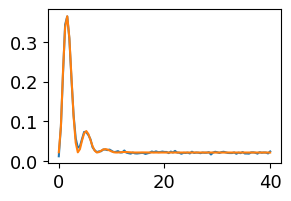

freq:0.13749383755001476,gamma: 0.5085875122240406, amp:0.8106445763378011, phase_deg: -1.5718855751172804,offset: 0.021936275646567922,
J = 0.9: Angular freq (rad/µs): 0.8638992599219897


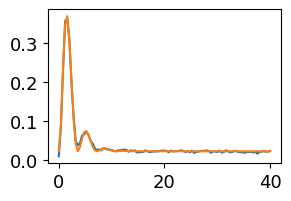

freq:0.13912261688737648,gamma: 0.526863332755111, amp:0.836592080306426, phase_deg: -1.5858440543945638,offset: 0.02327551425682681,
J = 0.91: Angular freq (rad/µs): 0.8741331823231385


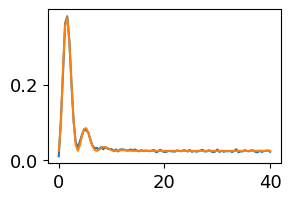

freq:0.14087843270112516,gamma: 0.4971858412949061, amp:0.8079864480015424, phase_deg: -0.9997620477488438,offset: 0.024506695241936143,
J = 0.92: Angular freq (rad/µs): 0.8851652984461977


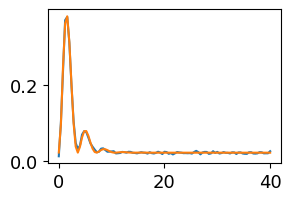

freq:0.1413128072267979,gamma: 0.5157342905748025, amp:0.8406360705447177, phase_deg: -1.1612388950492314,offset: 0.022917382277693653,
J = 0.93: Angular freq (rad/µs): 0.8878945540837178


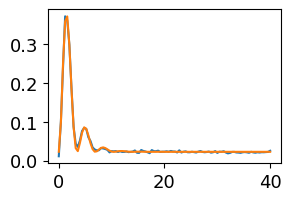

freq:0.14463321927859646,gamma: 0.49757413404784484, amp:0.7861097166270781, phase_deg: -0.7389787858224991,offset: 0.02298764222725494,
J = 0.9400000000000001: Angular freq (rad/µs): 0.9087573183013605


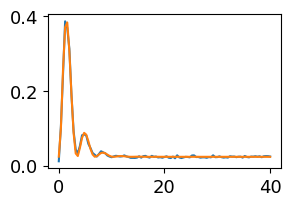

freq:0.14545628141452124,gamma: 0.5059130122244563, amp:0.8223893180792201, phase_deg: -1.2452933489888502,offset: 0.023631315327778096,
J = 0.9500000000000001: Angular freq (rad/µs): 0.913928770220699


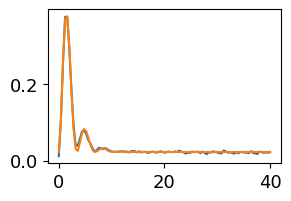

freq:0.1457451933072948,gamma: 0.5256048835483317, amp:0.8329831171177001, phase_deg: -0.6360330155688488,offset: 0.022664321894864326,
J = 0.96: Angular freq (rad/µs): 0.9157440571804433


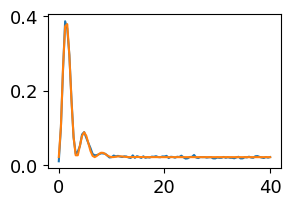

freq:0.14830078630401394,gamma: 0.5062769392443335, amp:0.8106903781476104, phase_deg: -0.9435512462069898,offset: 0.02193548342526251,
J = 0.97: Angular freq (rad/µs): 0.93180132154856


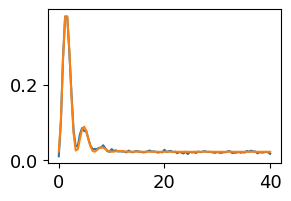

freq:0.14978940723608783,gamma: 0.5139920290487782, amp:0.8215893363542216, phase_deg: -0.9971907497156741,offset: 0.02223772347503401,
J = 0.98: Angular freq (rad/µs): 0.9411546027169266


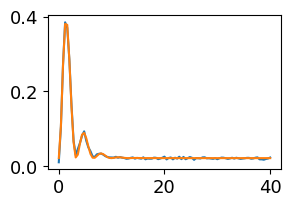

freq:0.15167210060611483,gamma: 0.513936847644978, amp:0.8131611594659006, phase_deg: -0.866112071222865,offset: 0.02191818949573004,
J = 0.99: Angular freq (rad/µs): 0.9529839140374047


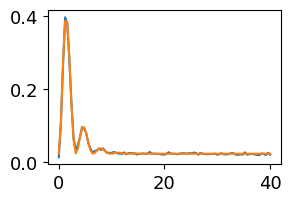

freq:0.15411857666909737,gamma: 0.49886424769798066, amp:0.8032846050119622, phase_deg: -1.2889932943277869,offset: 0.02196383846990626,
J = 1.0: Angular freq (rad/µs): 0.9683555764907031


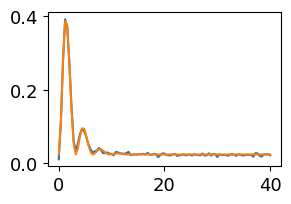

freq:0.15497046928139466,gamma: 0.5038206600195327, amp:0.7879040797205948, phase_deg: -0.258779756130982,offset: 0.02354670034353057,
J = 1.01: Angular freq (rad/µs): 0.9737081756355843


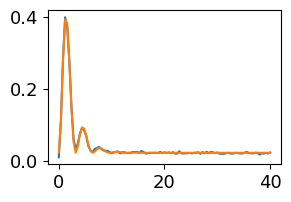

freq:0.15676732618799727,gamma: 0.5225574319971139, amp:0.8262506933355308, phase_deg: -1.2736397329609694,offset: 0.022794470451660512,
J = 1.02: Angular freq (rad/µs): 0.984998160550254


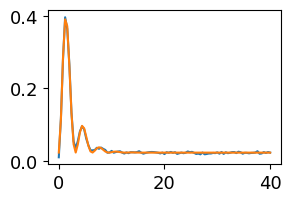

freq:0.15890318907322917,gamma: 0.5142092939174998, amp:0.7971297455447822, phase_deg: -0.7892277563805795,offset: 0.02219639261548603,
J = 1.03: Angular freq (rad/µs): 0.9984181828488933


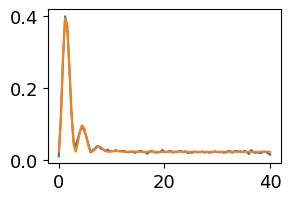

freq:0.15993318645106164,gamma: 0.5218671333922753, amp:0.8082011377079887, phase_deg: -0.8653237899066186,offset: 0.02228796749377791,
J = 1.04: Angular freq (rad/µs): 1.0048898472397239


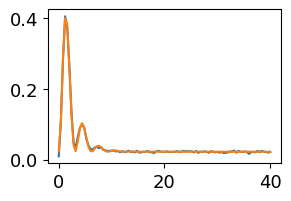

freq:0.16252634960314774,gamma: 0.507766819481312, amp:0.8062674346996742, phase_deg: -1.9945247884199344,offset: 0.02255500963481762,
J = 1.05: Angular freq (rad/µs): 1.0211831718560307


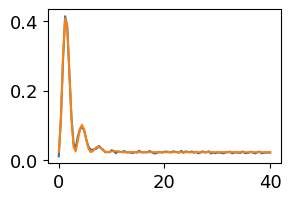

freq:0.16404869205694747,gamma: 0.5242499018971088, amp:0.8271738641890821, phase_deg: -1.817249517077366,offset: 0.023009711364126283,
J = 1.06: Angular freq (rad/µs): 1.0307483315942407


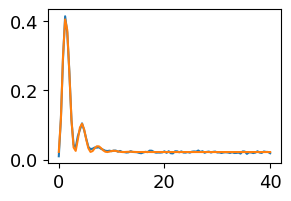

freq:0.16469904303936891,gamma: 0.512421458412508, amp:0.8060136836487244, phase_deg: -1.3220470385519991,offset: 0.02176540639966481,
J = 1.07: Angular freq (rad/µs): 1.0348346073315011


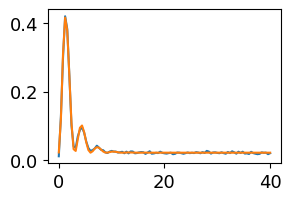

freq:0.1668214289445771,gamma: 0.5332133822145635, amp:0.8420211502308003, phase_deg: -1.6443648618510907,offset: 0.021637720341198322,
J = 1.08: Angular freq (rad/µs): 1.0481699512672702


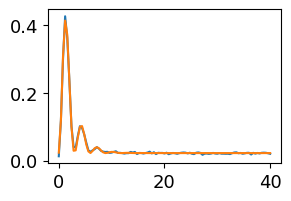

freq:0.16973698496406323,gamma: 0.5300930588897931, amp:0.825561454571813, phase_deg: -2.157645720712543,offset: 0.022596435864550433,
J = 1.09: Angular freq (rad/µs): 1.0664889300111644


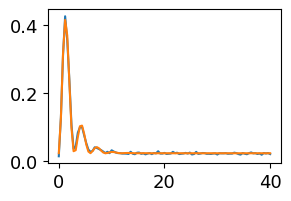

freq:0.16922872769051583,gamma: 0.5217717568170994, amp:0.8104898862534521, phase_deg: -0.9080296155749012,offset: 0.0230857633461851,
J = 1.1: Angular freq (rad/µs): 1.0632954553777443


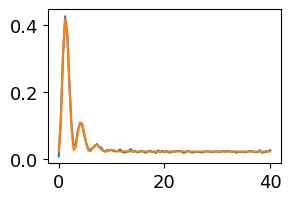

freq:0.1719887810613479,gamma: 0.5130751519114477, amp:0.8083302612168924, phase_deg: -1.8070854310708944,offset: 0.022187321470143413,
J = 1.11: Angular freq (rad/µs): 1.0806373821643878


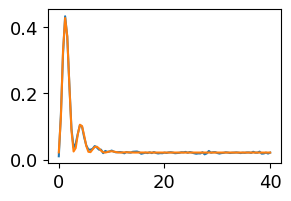

freq:0.17252085250968185,gamma: 0.5354660388302869, amp:0.8410296194362015, phase_deg: -1.376785204738151,offset: 0.021540867692259335,
J = 1.12: Angular freq (rad/µs): 1.0839804856709294


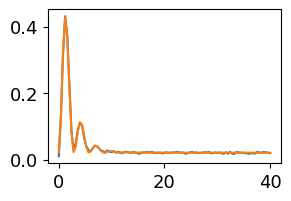

freq:0.17502379575966728,gamma: 0.5169780395254828, amp:0.8223080127557725, phase_deg: -1.9536828401175135,offset: 0.02120452389938686,
J = 1.1300000000000001: Angular freq (rad/µs): 1.0997069419239422


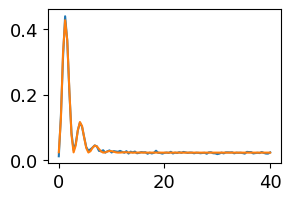

freq:0.17713512856865474,gamma: 0.5184350909715476, amp:0.8147071085838599, phase_deg: -2.083613803595719,offset: 0.022173339310201354,
J = 1.1400000000000001: Angular freq (rad/µs): 1.1129728372079384


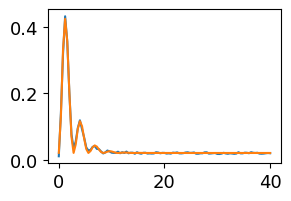

freq:0.1781241947792861,gamma: 0.5124991080710393, amp:0.7956419394719003, phase_deg: -1.2192852582148401,offset: 0.020604912610003127,
J = 1.1500000000000001: Angular freq (rad/µs): 1.119187323490405


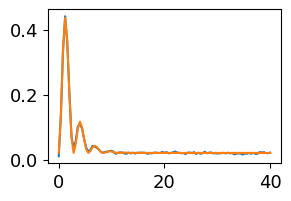

freq:0.178924252252194,gamma: 0.5243149599931957, amp:0.8294830356376126, phase_deg: -1.4509719149096372,offset: 0.020847149853875577,
J = 1.16: Angular freq (rad/µs): 1.1242142328490794


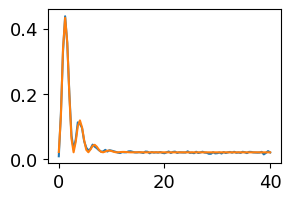

freq:0.18152465838276022,gamma: 0.5217182027625307, amp:0.8156443212385147, phase_deg: -1.9678518985809528,offset: 0.021407520633321908,
J = 1.17: Angular freq (rad/µs): 1.1405530664413528


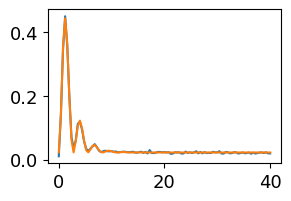

freq:0.18216549510863952,gamma: 0.5226312389566675, amp:0.8289430213088829, phase_deg: -1.5440860418483957,offset: 0.022558551666776047,
J = 1.18: Angular freq (rad/µs): 1.1445795623416986


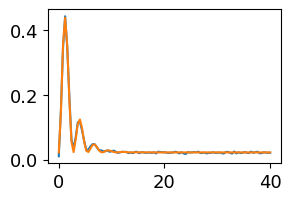

freq:0.18330245480071405,gamma: 0.5123649623820452, amp:0.8017978052524003, phase_deg: -0.6678129744165756,offset: 0.022321015909779172,
J = 1.19: Angular freq (rad/µs): 1.1517232907737966


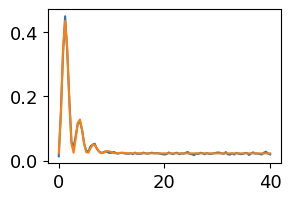

freq:0.18528213852117892,gamma: 0.49829552290243084, amp:0.7803157167276173, phase_deg: -1.0817223190510945,offset: 0.022603797898866344,
J = 1.2: Angular freq (rad/µs): 1.1641620104390842


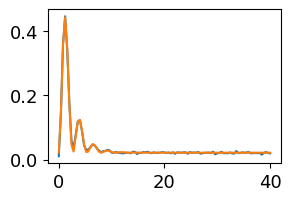

freq:0.18770137115935326,gamma: 0.5172341221340321, amp:0.8107754443982175, phase_deg: -1.4030480488993933,offset: 0.021687591411435465,
J = 1.21: Angular freq (rad/µs): 1.1793624974059105


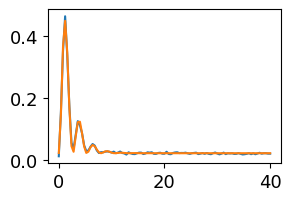

freq:0.18917735677554554,gamma: 0.5235063572726298, amp:0.8254137955720962, phase_deg: -1.6903715830842623,offset: 0.021691804390995918,
J = 1.22: Angular freq (rad/µs): 1.1886363885431783


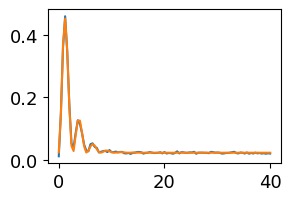

freq:0.1901579181074533,gamma: 0.5216211806569875, amp:0.8267854038767001, phase_deg: -2.0409162114920663,offset: 0.02290994044626335,
J = 1.23: Angular freq (rad/µs): 1.1947974370966097


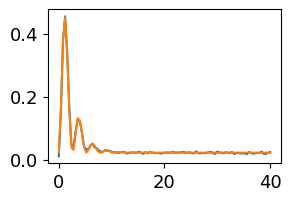

freq:0.19154470808178395,gamma: 0.515577131946166, amp:0.811428662705214, phase_deg: -0.5091094429508336,offset: 0.022434442429312945,
J = 1.24: Angular freq (rad/µs): 1.2035108954874678


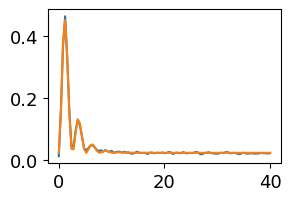

freq:0.19443281722931086,gamma: 0.5344107278536725, amp:0.8295361631241269, phase_deg: -1.6724671198082341,offset: 0.02380292025813616,
J = 1.25: Angular freq (rad/µs): 1.2216574204487398


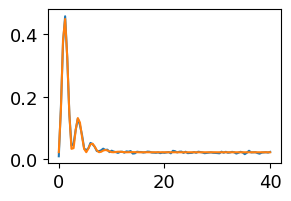

freq:0.1950648448165653,gamma: 0.5300513243507942, amp:0.818430094780825, phase_deg: -1.1373322418276692,offset: 0.022517293725756837,
J = 1.26: Angular freq (rad/µs): 1.2256285668987092


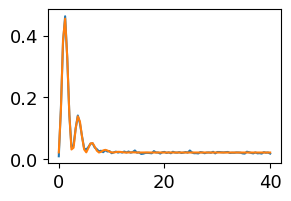

freq:0.19610430994371494,gamma: 0.5131290871136496, amp:0.8133858873404753, phase_deg: -1.1807688491707393,offset: 0.021672300895196825,
J = 1.27: Angular freq (rad/µs): 1.2321597189129414


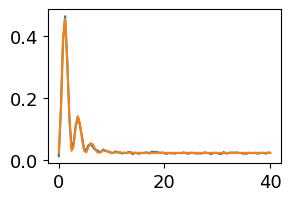

freq:0.1989183604706163,gamma: 0.5219706714433454, amp:0.8193400839136432, phase_deg: -1.5014280414154093,offset: 0.02246601677637171,
J = 1.28: Angular freq (rad/µs): 1.2498409198372291


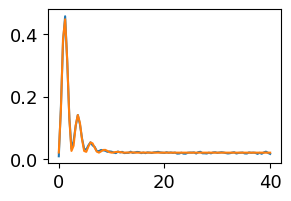

freq:0.19963316466907044,gamma: 0.5101474484670675, amp:0.7903719232103835, phase_deg: -1.3148645301549615,offset: 0.02105260065481242,
J = 1.29: Angular freq (rad/µs): 1.2543321670744663


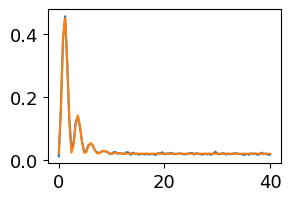

freq:0.20214474133914534,gamma: 0.517313300353337, amp:0.8028245105678219, phase_deg: -1.5044860327489766,offset: 0.0211544949837595,
J = 1.3: Angular freq (rad/µs): 1.270112868705736


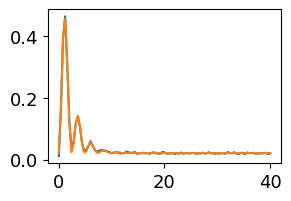

freq:0.2035560446647133,gamma: 0.5267015520281627, amp:0.8206134548271359, phase_deg: -1.9724180201653163,offset: 0.021581562995914544,
J = 1.31: Angular freq (rad/µs): 1.2789803490249183


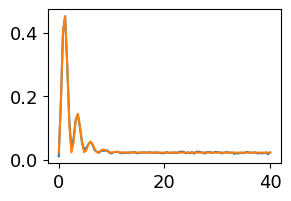

freq:0.20352020852437624,gamma: 0.5183673841490705, amp:0.797455461095595, phase_deg: 0.11222146287820038,offset: 0.022078462833073083,
J = 1.32: Angular freq (rad/µs): 1.2787551839144864


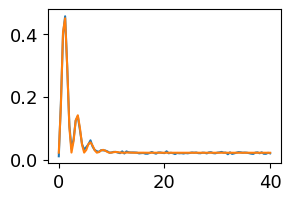

freq:0.20598973196690223,gamma: 0.5308672907021682, amp:0.8107660903634462, phase_deg: -0.9080230183760766,offset: 0.021576193073567354,
J = 1.33: Angular freq (rad/µs): 1.2942716573243012


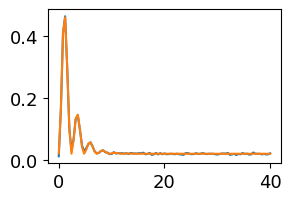

freq:0.20906221799134014,gamma: 0.520590121004222, amp:0.8182416651910289, phase_deg: -2.1354736462663784,offset: 0.021440597914380955,
J = 1.34: Angular freq (rad/µs): 1.313576656369564


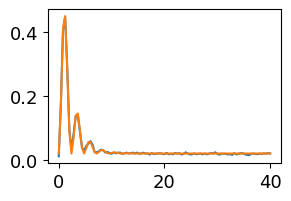

freq:0.21055905405103534,gamma: 0.5129869788460221, amp:0.7926873371871461, phase_deg: -1.2235781882846035,offset: 0.020900604300268417,
J = 1.35: Angular freq (rad/µs): 1.3229815547070976


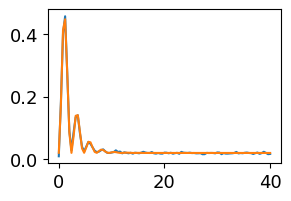

freq:0.21210738885799882,gamma: 0.5246713240463291, amp:0.8008141234015332, phase_deg: -1.3776396108908853,offset: 0.02060568021717834,
J = 1.36: Angular freq (rad/µs): 1.3327100292168053


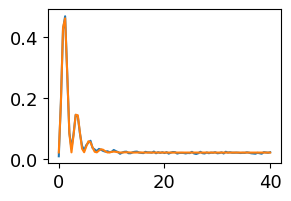

freq:0.2132818472142333,gamma: 0.530257962424213, amp:0.8318761124488937, phase_deg: -1.2452240592264563,offset: 0.022161040663069793,
J = 1.37: Angular freq (rad/µs): 1.340089368704592


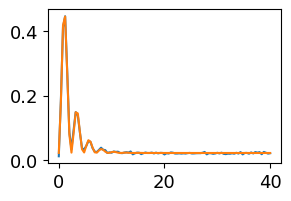

freq:0.21384603287357207,gamma: 0.5110560934377661, amp:0.7842162107531111, phase_deg: -0.7330221817156611,offset: 0.02124817623851934,
J = 1.3800000000000001: Angular freq (rad/µs): 1.3436342517498707


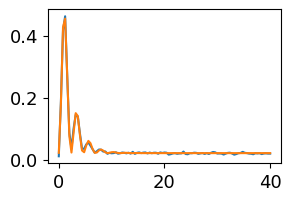

freq:0.2165235070270436,gamma: 0.5283117897947219, amp:0.8187037488890008, phase_deg: -1.8922266232387965,offset: 0.020832269902273163,
J = 1.3900000000000001: Angular freq (rad/µs): 1.3604573180113162


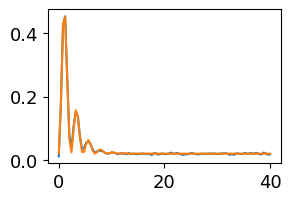

freq:0.21968138825530575,gamma: 0.5181687966229558, amp:0.8055265218010159, phase_deg: -2.0746824349010407,offset: 0.02011630267585473,
J = 1.4000000000000001: Angular freq (rad/µs): 1.3802988709465511


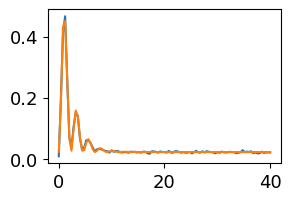

freq:0.21936246494456677,gamma: 0.5209553075045184, amp:0.8043624814385028, phase_deg: -1.548825567486065,offset: 0.022084905614752147,
J = 1.41: Angular freq (rad/µs): 1.378295016686399


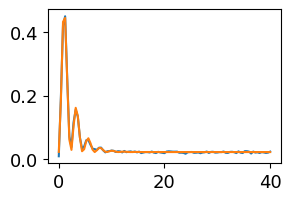

freq:0.22167891609385781,gamma: 0.5171232833719493, amp:0.7897840459028606, phase_deg: -1.494148648263633,offset: 0.02278222957291567,
J = 1.42: Angular freq (rad/µs): 1.3928497085124236


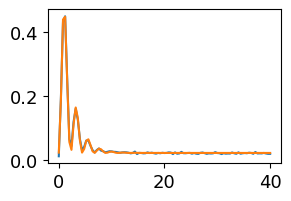

freq:0.2243669419958262,gamma: 0.5243207653042613, amp:0.8076222093405132, phase_deg: -1.9908130535261692,offset: 0.021973066432491934,
J = 1.43: Angular freq (rad/µs): 1.4097390733649897


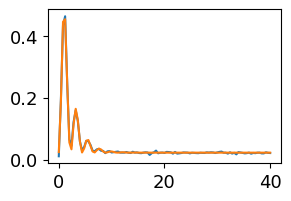

freq:0.2259257980746443,gamma: 0.5365755044596082, amp:0.8258655608629436, phase_deg: -2.662150896392399,offset: 0.022855720377881517,
J = 1.44: Angular freq (rad/µs): 1.4195336549754272


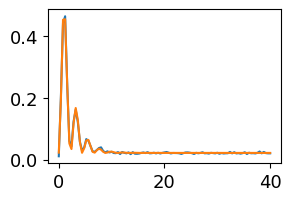

freq:0.22602643545794115,gamma: 0.5305110724436549, amp:0.8253144776089121, phase_deg: -1.8374403107882145,offset: 0.021880787948084852,
J = 1.45: Angular freq (rad/µs): 1.420165978303511


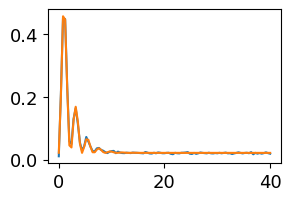

freq:0.22796570206805297,gamma: 0.5280364097809375, amp:0.8125055755986103, phase_deg: -1.0434072339850315,offset: 0.021654905531735,
J = 1.46: Angular freq (rad/µs): 1.4323507497748695


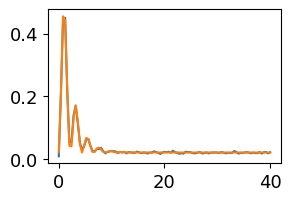

freq:0.2291988698074566,gamma: 0.517117781671253, amp:0.8007028329635237, phase_deg: -0.9612437028691607,offset: 0.02033423247328769,
J = 1.47: Angular freq (rad/µs): 1.440098971196378


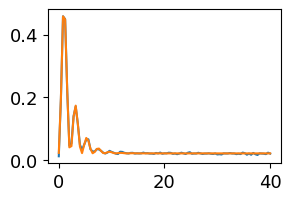

freq:0.23257585619575152,gamma: 0.522227871416282, amp:0.8143649072414397, phase_deg: -2.4816765391853752,offset: 0.02121692955670216,
J = 1.48: Angular freq (rad/µs): 1.4613172024538583


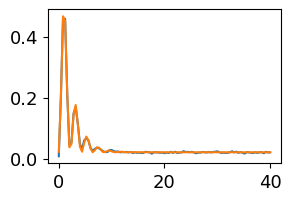

freq:0.23405130165757765,gamma: 0.520269297572083, amp:0.8196124538987226, phase_deg: -2.2440354767602946,offset: 0.021058895891228096,
J = 1.49: Angular freq (rad/µs): 1.470587699701149


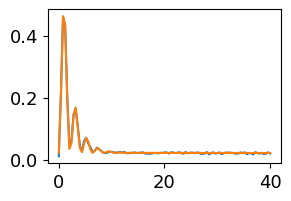

freq:0.2347625189966494,gamma: 0.5314311371121795, amp:0.8033026059849497, phase_deg: -1.316244911729309,offset: 0.021799689641165295,
J = 1.5: Angular freq (rad/µs): 1.475056410036216
J = 0.0: omega = 0.0037355664000309125 rad/µs
J = 0.01: omega = 0.0022526099755165565 rad/µs
J = 0.02: omega = 0.004847511757228429 rad/µs
J = 0.03: omega = 0.007796339951985489 rad/µs
J = 0.04: omega = 0.0010966573232394975 rad/µs
J = 0.05: omega = 0.06283185307179572 rad/µs
J = 0.06: omega = nan rad/µs
J = 0.07: omega = nan rad/µs
J = 0.08: omega = nan rad/µs
J = 0.09: omega = nan rad/µs
J = 0.1: omega = 0.009058116520325933 rad/µs
J = 0.11: omega = nan rad/µs
J = 0.12: omega = 0.008834974505694563 rad/µs
J = 0.13: omega = nan rad/µs
J = 0.14: omega = nan rad/µs
J = 0.15: omega = nan rad/µs
J = 0.16: omega = nan rad/µs
J = 0.17: omega = nan rad/µs
J = 0.18: omega = 0.009068563546861006 rad/µs
J = 0.19: omega = nan rad/µs
J = 0.2: omega = nan rad/µs
J = 0.21: omega = 0.012858981455615467 rad/µs
J = 0.22

In [34]:
probs_folder = os.path.join("sweep_J_data", "probs")
values_folder = os.path.join("sweep_J_data", "values")
probability_dataframes = {}
for J in J_list:
    prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
    values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")

    # If both files already exist, load them and skip this iteration
    if os.path.exists(prob_filename) and os.path.exists(values_filename):
        with open(prob_filename, "rb") as f:
            df_prob = pickle.load(f)
        probability_dataframes[J] = df_prob
# probability_dataframes = 0
omega_dict = sweep_J_curve_fit(probability_dataframes)

# Print the results
for J, omega in omega_dict.items():
    print(f"J = {J}: omega = {omega} rad/µs")
J_vals = sorted(omega_dict.keys())
omegas = [omega_dict[J] for J in J_vals]




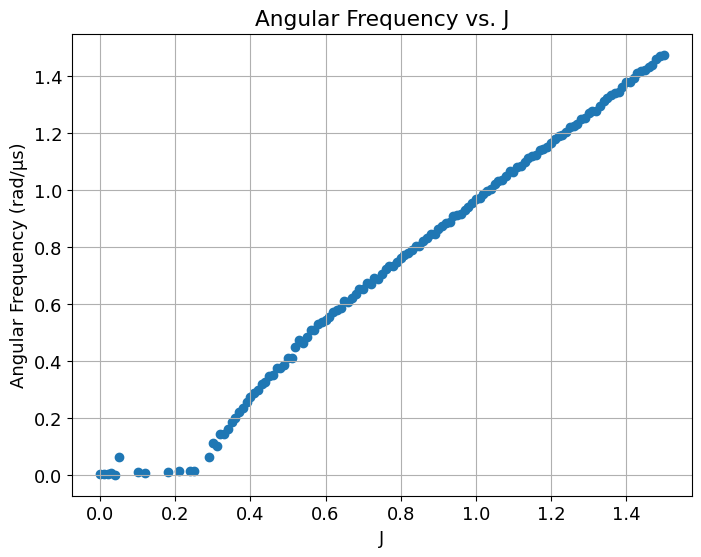

In [35]:
plt.figure(figsize=(8, 6))
plt.scatter(J_vals, omegas, marker="o")
plt.xlabel("J")
plt.ylabel("Angular Frequency (rad/µs)")
plt.title("Angular Frequency vs. J")
plt.grid(True)
plt.show()

In [67]:
def fit_func(J, A, J0):
    """
    Model function: Re(A * sqrt(J - J0^2)).
    
    For each value in J, computes A*sqrt(J - J0^2) if J - J0^2 is nonnegative;
    otherwise returns 0.
    
    Parameters:
        J : array_like
            The independent variable.
        A : float
            Amplitude scaling factor.
        J0 : float
            Parameter inside the square root.
    
    Returns:
        array_like : The computed model values.
    """
    expr = J**2 - J0**2
    return np.where(expr >= 0, A * np.sqrt(expr), 0.0)

def curve_fit_function(J_data, y_data, initial_guess_A=1.0, initial_guess_J0=1.0):
    """
    Fits the data (J_data, y_data) to the function
         f(J) = Re(A * sqrt(J - J0^2))
    using the provided initial guesses for A and J0.
    
    Parameters:
        J_data : array_like
            The independent variable data.
        y_data : array_like
            The dependent variable data.
        initial_guess_A : float, optional
            Initial guess for the amplitude A (default is 1.0).
        initial_guess_J0 : float, optional
            Initial guess for the parameter J0 (default is 1.0).
    
    Returns:
        popt : ndarray
            Optimal values for the parameters [A, J0].
        pcov : 2D ndarray
            The estimated covariance of popt.
    """
    popt, pcov = curve_fit(fit_func, J_data, y_data, p0=[initial_guess_A, initial_guess_J0])
    return popt, pcov

def curve_fit_and_plot(J_data, y_data, initial_guess_A=1.0, initial_guess_J0=1.0):
    """
    Fits the given data to the model function f(J) = Re(A * sqrt(J - J0^2))
    and plots the original data (as a scatter plot) along with the fitted curve.
    
    Parameters:
        J_data : array_like
            The independent variable data.
        y_data : array_like
            The dependent variable data.
        initial_guess_A : float, optional
            Initial guess for the amplitude A (default is 1.0).
        initial_guess_J0 : float, optional
            Initial guess for the parameter J0 (default is 1.0).
    
    Returns:
        popt : ndarray
            The optimal parameters [A, J0] from the curve fitting.
        pcov : 2D ndarray
            The covariance matrix of the fitted parameters.
    """
    # Perform the curve fit
    popt, pcov = curve_fit_function(J_data, y_data, initial_guess_A, initial_guess_J0)
    fitted_A, fitted_J0 = popt
    print("Fitted A =", fitted_A)
    print("Fitted J0 =", fitted_J0)
    
    # Generate a smooth set of points for plotting the fitted curve
    J_fit = np.linspace(np.min(J_data), np.max(J_data), 1000)
    y_fit = fit_func(J_fit, fitted_A, fitted_J0)
    
    # Create the plot: scatter for original data and line for fitted curve
    plt.figure(figsize=(8, 5))
    plt.plot(J_fit, y_fit, label="Fitted Curve", color="red", linewidth=2)
    plt.scatter(J_data, y_data, label="Original Data", color="blue", s=30, alpha = .5)
    plt.xlabel("J")
    plt.ylabel("alpha=Re(A * sqrt(J^2 - J0^2))")
    plt.title("alpha vs J")
    plt.legend()
    # plt.grid(True)
    plt.show()
    
    return popt, pcov

C:\Users\quantum1\AppData\Local\Temp\ipykernel_18004\907047747.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.where(expr >= 0, A * np.sqrt(expr), 0.0)


Fitted A = 1.0050361205463685
Fitted J0 = 0.2852298453828185


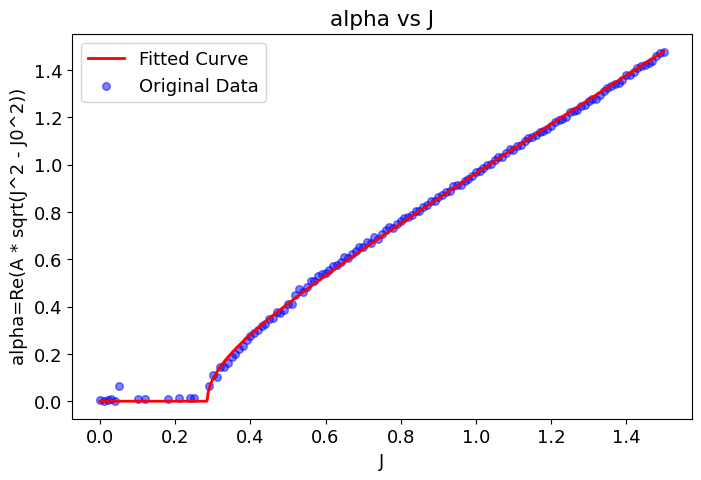

In [68]:
# Set initial guesses based on your expectations:
initial_guess_J0 = 0.1  # for example
initial_offset = 0.0  # for example
mask_rb = ~np.isnan(omegas)
# Assuming J_vals and omegas are defined and mask_rb selects the non-NaN entries.
J_vals_array = np.array(J_vals)[mask_rb]
omegas_array = np.array(omegas)[mask_rb]

# Set your initial guess values
initial_guess_J0 = 0.2# for example
initial_guess_A0 = 1
# Now, call your curve fitting and plotting function with the first 100 data points.
popt, pcov = curve_fit_and_plot(J_vals_array, omegas_array, initial_guess_A0,initial_guess_J0)


<Figure size 960x720 with 0 Axes>

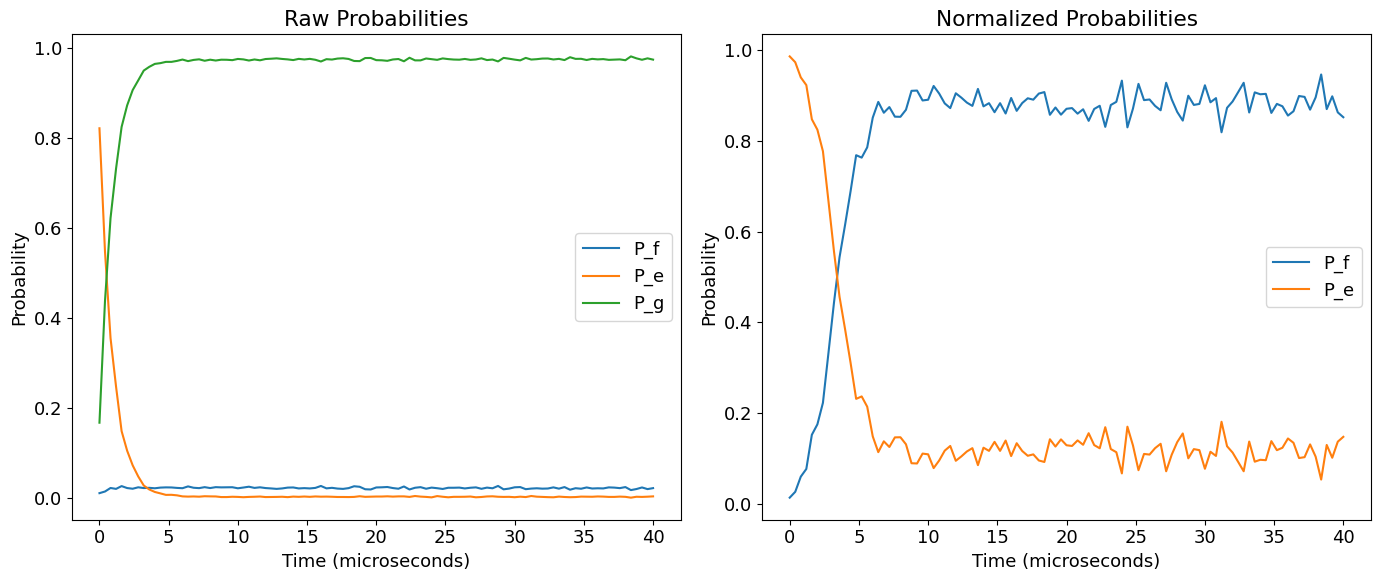

In [40]:
J = 0.02

probs_folder = os.path.join("sweep_J_data", "probs")
pkl_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")

with open(pkl_filename, "rb") as f:
    probability_dataframes = pickle.load(f)  # This is your DataFrame for J=2

# Assuming probability_dataframes is the DataFrame loaded for J=2
# Extract the raw probabilities into an array (if needed)
measured_pop = np.array([
    probability_dataframes["P_g"],
    probability_dataframes["P_e"],
    probability_dataframes["P_f"]
])

# Compute normalization factor (using P_f and P_e)
normalization_val = probability_dataframes["P_f"] + probability_dataframes["P_e"]

# Create a new DataFrame with normalized probabilities
normalized_df = pd.DataFrame({
    "time": probability_dataframes["time"],
    "P_f": probability_dataframes["P_f"] / normalization_val,
    "P_e": probability_dataframes["P_e"] / normalization_val,
    "P_g": probability_dataframes["P_g"] / normalization_val,
})

# List of keys to plot
keys = ["P_f", "P_e", "P_g"]

# Create figure and two subplots
plt.figure(dpi=150)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot raw probabilities in the first subplot
for key in keys:
    sns.lineplot(data=probability_dataframes, x="time", y=key, ax=axes[0], label=key)

# Plot normalized probabilities in the second subplot (skip "P_g" if desired)
for key in keys:
    if key != "P_g":  # Plot only P_f and P_e for normalization if that’s your intention
        sns.lineplot(data=normalized_df, x="time", y=key, ax=axes[1], label=key)

# Set labels and titles for clarity
axes[0].set_xlabel("Time (microseconds)")
axes[0].set_ylabel("Probability")
axes[0].set_title("Raw Probabilities")
axes[0].legend()

axes[1].set_xlabel("Time (microseconds)")
axes[1].set_ylabel("Probability")
axes[1].set_title("Normalized Probabilities")
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



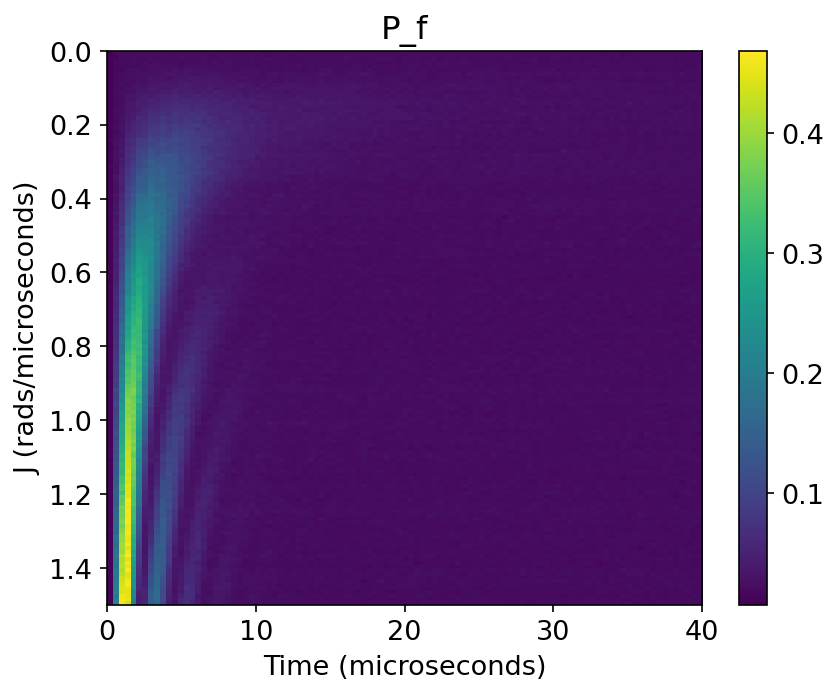

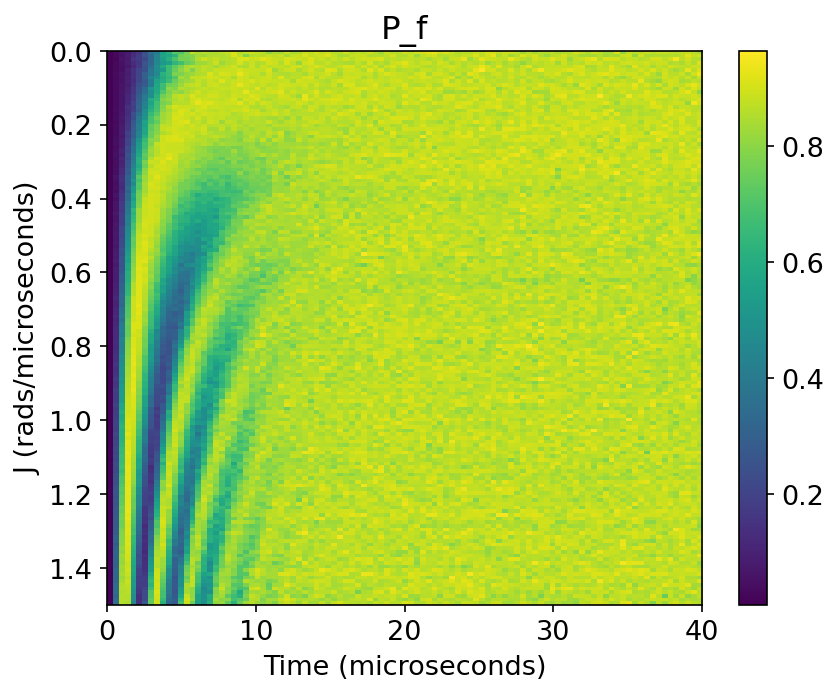

In [15]:
# Define parameters
num_steps = 101
sweep_time = 40000  # in microseconds
J_start = 0        # starting J value
J_stop = 1.5       # ending J value
J_steps = 151       # number of J values

# Generate an array of J values
J_vals = np.linspace(J_start, J_stop, J_steps)

# Initialize a 2D array to store normalized P_f values
p_f = np.zeros((J_steps, num_steps))
p_f_norm = np.zeros((J_steps, num_steps))
# Loop over each J value, and calculate the normalized P_f
for i, J in enumerate(J_vals):
    probs_folder = os.path.join("sweep_J_data", "probs")
    pkl_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")

    with open(pkl_filename, "rb") as f:
        probability_dataframes = pickle.load(f)

      # This is your DataFrame for J=2
    # Access the DataFrame for the current J
    df = probability_dataframes
    
    # Compute normalized P_f using P_f / (P_f + P_e)
    p_f[i] = df["P_f"] #/ (df["P_f"] + df["P_e"])
    p_f_norm[i] = df["P_f"] / (df["P_f"] + df["P_e"])

# Create the 2D plot
plt.figure(dpi=150)
# extent: [x_min, x_max, y_min, y_max] where time is on x and J on y.
plt.imshow(p_f, extent=[0, sweep_time / 1000, J_stop, J_start], aspect="auto")
plt.colorbar()
plt.ylabel("J (rads/microseconds)")
plt.xlabel("Time (microseconds)")
plt.title("P_f")
plt.show()

plt.figure(dpi=150)
# extent: [x_min, x_max, y_min, y_max] where time is on x and J on y.
plt.imshow(p_f_norm, extent=[0, sweep_time / 1000, J_stop, J_start], aspect="auto")
plt.colorbar()
plt.ylabel("J (rads/microseconds)")
plt.xlabel("Time (microseconds)")
plt.title("P_f")
plt.show()

In [16]:
probability_dataframes

,time,P_f,P_e,P_g
0.0,0.0,0.011000,0.826833,0.162167
0.4,0.4,0.210167,0.385500,0.404333
0.8,0.8,0.460833,0.075167,0.464000
1.2,1.2,0.433333,0.080000,0.486667
1.6,1.6,0.201667,0.248000,0.550333
...,...,...,...,...
38.4,38.4,0.021333,0.002333,0.976333
38.8,38.8,0.018333,0.003000,0.978667
39.2,39.2,0.019500,0.002333,0.978167
39.6,39.6,0.023500,0.003667,0.972833


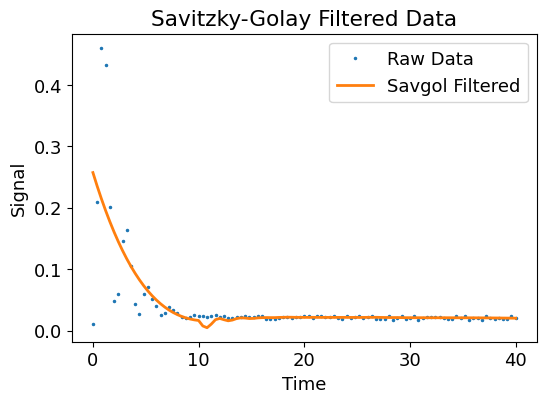

In [17]:
# Apply Savitzky-Golay filter
window_length = 51  # must be odd; try 7, 9, 11, ...
poly_order =3     # polynomial order
y_filtered = savgol_filter(probability_dataframes["P_f"] , window_length, poly_order)

# Plot the filtered data
plt.figure(figsize=(6,4))
plt.plot(probability_dataframes["time"], probability_dataframes["P_f"], '.', label="Raw Data", markersize=3)
plt.plot(probability_dataframes["time"], y_filtered, '-', label="Savgol Filtered", linewidth=2)
plt.xlabel("Time")
plt.ylabel("Signal")
plt.title("Savitzky-Golay Filtered Data")
plt.legend()
plt.show()

<Figure size 960x720 with 0 Axes>

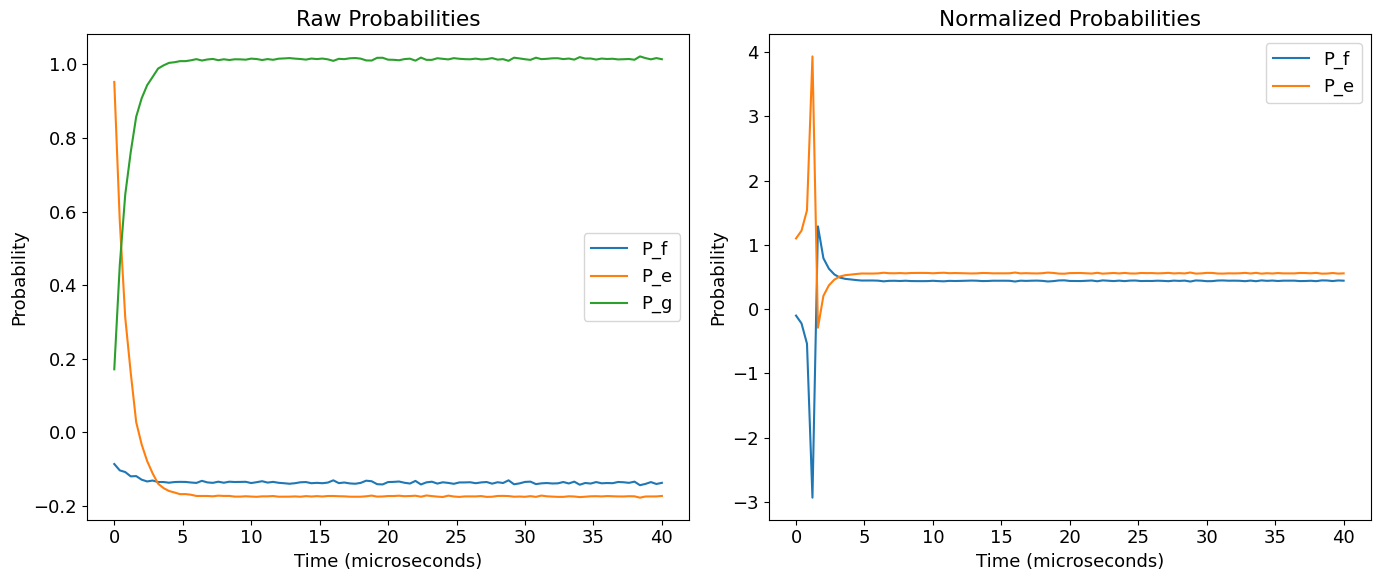

In [18]:
scale_matrix = np.array([
    [0.96513333, 0.00563333, 0.02923333],
    [0.14921667, 0.8369,     0.01388333],
    [0.14105,    0.05938333, 0.79956667]
])
inv_matrix = np.linalg.inv(scale_matrix)
scaled_pop =np.matmul(inv_matrix,measured_pop )
scaled_df = pd.DataFrame({
    "time": probability_dataframes["time"],
    "P_f": scaled_pop[2],
    "P_e": scaled_pop[1],
    "P_g": scaled_pop[0],
})
# Compute normalization factor (using P_f and P_e)
normalization_val_scaled = scaled_pop[1]+scaled_pop[2]

# Create a new DataFrame with normalized probabilities
normalized_scaled_df = pd.DataFrame({
    "time": probability_dataframes["time"],
    "P_f": scaled_pop[2]/normalization_val_scaled,
    "P_e": scaled_pop[1]/normalization_val_scaled,
    "P_g": scaled_pop[0]/normalization_val_scaled,
})
# List of keys to plot
keys = ["P_f", "P_e", "P_g"]

# Create figure and two subplots
plt.figure(dpi=150)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot raw probabilities in the first subplot
for key in keys:
    sns.lineplot(data=scaled_df, x="time", y=key, ax=axes[0], label=key)

# Plot normalized probabilities in the second subplot (skip "P_g" if desired)
for key in keys:
    if key != "P_g":  # Plot only P_f and P_e for normalization if that’s your intention
        sns.lineplot(data=normalized_scaled_df, x="time", y=key, ax=axes[1], label=key)

# Set labels and titles for clarity
axes[0].set_xlabel("Time (microseconds)")
axes[0].set_ylabel("Probability")
axes[0].set_title("Raw Probabilities")
axes[0].legend()

axes[1].set_xlabel("Time (microseconds)")
axes[1].set_ylabel("Probability")
axes[1].set_title("Normalized Probabilities")
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [19]:
# Initialize a dictionary to store the probability DataFrames for each J value
probability_dataframes = {}

# Loop over each J value and load the corresponding pickle file if it exists
for J in J_list:
    prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
    values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")
    
    if os.path.exists(prob_filename) and os.path.exists(values_filename):
        with open(prob_filename, "rb") as f:
            df_prob = pickle.load(f)
        probability_dataframes[J] = df_prob
    else:
        print(f"Data for J = {J:.3f} not found. Skipping.")

# ---------------------------
# 2. Prepare Data for 2D Plotting
# ---------------------------

# Define parameters for the sweep
num_steps = 51      # number of time steps (should match what you used when saving the data)
sweep_time = 20000  # total sweep time in microseconds

# Initialize a 2D array to hold the normalized P_f values
p_f = np.zeros((J_steps, num_steps))

# For each J value, compute the normalized P_f as P_f / (P_f + P_e)
for i, J in enumerate(J_list):
    df = probability_dataframes.get(J)
    if df is not None:
        # Compute normalized P_f
        p_f[i] = df["P_f"] / (df["P_f"] + df["P_e"])
    else:
        # Fill with NaN if data is missing for a specific J
        p_f[i] = np.nan

# ---------------------------
# 3. Create the 2D Plot
# ---------------------------

plt.figure(dpi=150)
# The extent parameter maps the array indices to real data coordinates:
# [x_min, x_max, y_min, y_max]
plt.imshow(p_f, extent=[0, sweep_time/1000, J_stop, J_start], aspect="auto")
plt.colorbar(label="Normalized P_f")
plt.xlabel("Time (microseconds)")
plt.ylabel("J (rads/microseconds)")
plt.title("2D Heatmap of Normalized P_f vs Time and J")
plt.show()

ValueError: could not broadcast input array from shape (101,) into shape (51,)